In [ ]:
#from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
#from google.colab import auth
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import json
from datetime import datetime
import pandas as pd
import numpy as np
import csv
import re # regular expressinons
import openpyxl # library to work with excel docs
from pprint import pprint

# Relevant Assets in Administrative Data

We will investigate available administrative data in order to determine which nouns should be considered assets. This work is building from an initial proof-of-concept Jupyterbook for commodity counting of the Ur III texts from Drehem, ancient Puzriš-Dagan.

* [Sumerian Networks JupyterBook: Commodities Counting](https://niekveldhuis.github.io/sumnet/PartVII-CommoditiesCounting.html)

## Outline

0.   Ur III Text Data
1.   Administrative Texts Data Filter
2.   Import Cuneiform Dictionary Units
3.   Cuneiform Number Translation
4.   Segment Scanner
5.   Determine Assets
  

## Dataset:

We can begin with the __Ur III texts (ca. 80k)__. These ara all in Sumerian, so we will want to work with another corpus for Akkadian terms, but because the Sumerian terms are used in the Akkadian texts, this will be useful for the next corpus as well.

* Source: [ORACC Ur3 Administrative texts online](http://oracc.museum.upenn.edu/epsd2/admin/ur3/corpus)

* Includes:
  * [Lemmatized Ur 3 data in CSV format](https://drive.google.com/file/d/1FF6iTT5ImqOr_o2GVYcrH6Yviw0aHyvL/view?usp=drive_link)
  * [Catalog metadata for the Ur 3 texts](https://drive.google.com/file/d/10VCBsJTN6seuKFOIatfVn0O7NvpXlZAb/view?usp=drive_link)




#### __Guides for Part of Speech (pos) or Effective Part of Speech (epos)__:

__General pos / epos__
* [ORACC](http://oracc.museum.upenn.edu/doc/help/languages/akkadian/index.html) (scroll down to half the page)
* [UD](http://universaldependencies.org/docs/en/pos/all.html) (Universal Dependencies)
* [Penn](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) (Penn Treebank)


__Proper Nouns__
* [ORACC pos tags for proper nouns](http://oracc.museum.upenn.edu/doc/help/languages/propernouns/index.html):

| Oracc_POS | Oracc_Meaning | Oracc_Class | Wikidata Q-item | Pseud-lang |
| --------- | ------------- | ----------- | --------------- | ---------- |
|AN|Agricultural (locus) Name|Places|[Q115642008](https://www.wikidata.org/wiki/Q115642008)|qpn-x-people|
|CN|Celestial Name|Celestial|[Q115642031](https://www.wikidata.org/wiki/Q115642031)|qpn-x-celest|
|DN|Divine Name|Divine|[Q115642037](https://www.wikidata.org/wiki/Q115642037)|qpn-x-divine|
|EN|Ethnos Name|Ethnic|[Q115642056](https://www.wikidata.org/wiki/Q115642056)|qpn-x-ethnic|
|GN|Geographical Name (lands and other geographical entities without their own tag)|Places|[Q115642059](https://www.wikidata.org/wiki/Q115642059)|qpn-x-places|
|LN|Line Name (ancestral clan)|People|[Q115642077](https://www.wikidata.org/wiki/Q115642077)|qpn-x-people|
|ON|Object Name|Object|[Q115642085](https://www.wikidata.org/wiki/Q115642085)|qpn-x-object|
|PN|Personal Name|People|[Q115642094](https://www.wikidata.org/wiki/Q115642094)|qpn-x-people|
|QN|Quarter Name (city area)|Places|[Q115642100](https://www.wikidata.org/wiki/Q115642100)|qpn-x-places|
|RN|Royal Name|People|[Q115642102](https://www.wikidata.org/wiki/Q115642102)|qpn-x-people|
|SN|Settlement Name|Places|[Q115642103](https://www.wikidata.org/wiki/Q115642103)|qpn-x-places|
|TN|Temple Name|Temples|[Q115642104](https://www.wikidata.org/wiki/Q115642104)|qpn-x-temple|
|WN|Watercourse Name|Watercourses|[Q115642106](https://www.wikidata.org/wiki/Q115642106)|qpn-x-waters|
|YN|Year Name|Year name|[Q115642111](https://www.wikidata.org/wiki/Q115642111)|qpn-x-ynames|
|FN|Field Name|Places|[Q1434274](https://www.wikidata.org/wiki/Q1434274)|qpn-x-places|
|MN|Month Name|Month|[Q56413401](https://www.wikidata.org/wiki/Q56413401)|qpn-x-months|


##0 Read in the Ur III text data

We obtained the collection of Ur III texts from ORACC in another notebook and exported the data in a CSV file which we can read in here.

In [ ]:
colab_path = "/content/drive/MyDrive/FactGrid Cuneiform (AWCA)/Econ/Data/epsd2-admin-ur3-df-cat.csv"

file_path = "Data/epsd2-admin-ur3-df-cat.csv"

cat_df = pd.read_csv(file_path)
cat_df.head(10)

/var/folders/ml/q33bqpt97qb6rw4m3p1_kftw0000gn/T/ipykernel_7679/3413019356.py:5: DtypeWarning: Columns (23,27,35,39,40,41,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  cat_df = pd.read_csv(file_path)


,id_text,langs,project,id_text.1,designation,period,subgenre,genre,supergenre,provenience,...,published_collation,author_remarks,google_earth_collection,seal_information,subgenre_remarks,photo_up,provenience_remarks,date_remarks,electronic_publication,object_remarks
0,P255173,0x02000000,epsd2/praxis/liturgy,P255173,UM 29-13-180,Old Babylonian,Narratives featuring deities//Other deities,Literary,LIT,Nippur,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P257677,0x02000000,epsd2/praxis/liturgy,P257677,"CBS 00112 = PBS 10/2, 13",Old Babylonian,Balag,Liturgy,unknown,uncertain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P259270,0x02000000,epsd2/praxis/liturgy,P259270,CBS 02218 + CBS 02334 + N 3335 + N 3369 + N 42...,Old Babylonian,Balag,Liturgy,unknown,Nippur,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P266508,0x02000000,epsd2/praxis/liturgy,P266508,"CBS 11359 = PBS 01/1, 08",Old Babylonian,Balag,Liturgy,unknown,Nippur,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P266524,0x02000000,epsd2/praxis/liturgy,P266524,CBS 11378,Ur III,NaN,Administrative,ELA,Nippur,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,P266687,0x08000000,epsd2/praxis/liturgy,P266687,CBS 11545,Middle Babylonian,NaN,Administrative,ELA,Nippur,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,P274214,0x02000000,epsd2/praxis/liturgy,P274214,"BM 055290 = CT 58, 19",Old Babylonian,Balag,Liturgy,unknown,Sippar-Yahrurum,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,P278997,0x02000000,epsd2/praxis/liturgy,P278997,N 4120 + N 7261,Old Babylonian,Narratives featuring heroes//Lugalbanda and En...,Literary,LIT,Nippur,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,P283761,0x02000000,epsd2/praxis/liturgy,P283761,"BM 054707 = CT 42, 48 BM 054707",Neo-Babylonian,Balag,Liturgy,unknown,uncertain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,P310385,0x02000000,epsd2/praxis/liturgy,P310385,"YBC 09838 = CanLament 347-73, 835-36",Old Babylonian,Balag,Liturgy,unknown,uncertain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##1 Administrative Data Filter

Filter the words_df dataframe to only contain relevant administrative text data



In [ ]:
# Find the text data labeled as Administrative in order to later adjust the words_df text data to only include administrative data
only_administrative = cat_df[cat_df['genre']=='Administrative']

TO DO: The last two pieces of code filter out texts that contain the word total to prevent double counting. Work on using the total as a way of checking if the counts are correct and determining an accurate total per text.

In [ ]:
# Warning: this will download the csv and then make read it in as a csv.
# Should not take more than 5 minutes
url = 'https://zenodo.org/records/10794626/files/finaldf.csv?download=1'
words_df = pd.read_csv(url)

# Filters word_df to Sumerian text only
words_df = words_df[(words_df['lang']=='sux') | (words_df['lang']=='sux-x-emesal')]

# Filters word_df to Administrative text only
words_df = words_df[words_df['id_text'].isin(only_administrative['id_text'])]

#Get rid of text containing total to prevent double counting (To do: Work on using the total as a way of checking if the counts are correct)
text_containing_total = words_df[words_df['gw'] == "total"]

#Exclude id_text containing the word total
words_df = words_df[~words_df['id_text'].isin(text_containing_total['id_text'])]

/var/folders/ml/q33bqpt97qb6rw4m3p1_kftw0000gn/T/ipykernel_7679/2103714609.py:4: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  words_df = pd.read_csv(url)


In [ ]:
len(words_df)

2220411

In [ ]:
words_df['id_text'].value_counts()

id_text
P500114    2254
P250589    1745
P375996    1495
P250739    1465
P137823    1446
           ... 
P456541       1
P252038       1
P138749       1
P332299       1
P456808       1
Name: count, Length: 68798, dtype: int64

Note: According to the number of rows above, there are **77045 Administrative Texts**

##2 Import Cuneiform Dictionary and Unique Units

Note: Both the dictionary and the list of unique units are built from the Weight_measures excel file in the Cuneiform Dictionary folder. Therefore, if there needs to be changes, it should be done in the Weight_measures excel file for those changes to automatically translate in this notebook.

In [ ]:
import pickle

colab_path = "/content/drive/MyDrive/FactGrid Cuneiform (AWCA)/Econ/Data/weights_measures.pkl"

file_path = "Data/cuneiform_dict.pkl"

with open(file_path, 'rb') as f:
    unique_units_from_dict, combined_dict = pickle.load(f)

In [ ]:
counts_words_per_text = words_df['id_text'].value_counts()

In [ ]:
proper_nouns = ["AN", "CN", "DN", "EN", "GN", "LN", "ON", "PN", "QN", "RN", "SN", "TN", "WN", "YN", "FN", "MN"]

##3 Cuneiform Number Translation

With the use of the cuneiform number dictionary, we will build a function to help us translate these cuneiform numbers into equivalent english translations.

Beyond directly translating a single cuneiform digits, there are various instances throughout the word_df dataframe which contain sequences of cuneiform digits rather than a single digit. They come in forms such as '2(IKU)-1(IKU)-3(IKU)' or '2(IKU)+1(IKU)-3(IKU)'. To handle these cases, we will assume these were individuals doing the math on paper in the moment as transactions were occuring in front of them. To incorporate this into our translation, we must embed a calculator into our translation function to do the math of these sequences of numbers and output a single translated number.

--------------------------------------------------------------------------------
Future Improvements:

The dictionary containing the translated numbers is structured in a way to consider the units of a number because the unit will yield a completely different number. It is a dictionary where the key is the cuneiform number and the value is another dictionary containing 'NaN' (meaning there are no units associated with this number) or units most likely associated with the cuneiform number such as 'še' or 'gur'. The consideration of the unit has yet to be implemented into the single digit function. The default has been set to only translate the numbers to there no unit equivalent 'NaN'. This can be seen in the single digit function which has a default 'NaN' string set for the unit. What is needed is a way to capture the unit following the number and pass that unit into the function to begin translating these numbers based on their units.


In [ ]:
def extract_number_parts(text):
    pattern1 = r'(\d+\/?\d*\(?[\w₃₂₃ʾ@+×ā]+\)?)'
    return re.findall(pattern1, text)

def contains_nan_key(d):
    check = any(key =='NaN' for key in d.keys())
    return check

# Main Function: returns single digit translations
#                Also, breaks down sequences of digits, translates each of them,
#                and evaluates resulting expressions

def single_digit(cuneiform_digit, unit = 'NaN'):

  # Use the dictionary to find the translated version
  parts = extract_number_parts(cuneiform_digit)
  if len(parts) == 1:
    cuneiform_digit = parts[0]
    try:
      dictionary = combined_dict.get(cuneiform_digit)
      if contains_nan_key(dictionary):
        return dictionary[unit]
    except:
      return np.nan
  else:
     try:
      return translate_and_evaluate(cuneiform_digit)
     except:
      return np.nan
  return np.nan

# Following code deals with expressions embedded in cuneiform phrases such as '1(u)-1(diš)-kam-ma-am₃'
# (This code is also incorporated into the single digit to handle such cases)

# Substitutes cuneiform numbers with the translated digit

def sub_in_translated_numbers(text):
    pattern1 = '\d+\([\w₃₂ʾ@]+\)'
    return re.sub(pattern1,lambda m: str(single_digit(m.group())), text)

# Finds the mathematical expression in a given text that can be evaluated

      # EX: '1(u)-1(diš)' -> '10-1'

def find_expression(text):
    pattern2 = r'\d+(?:[+-]\d+)+'
    return re.findall(pattern2, text)[0] #ASSUMPTION: only one expression is in the given cuneiform set of numbers so it indexes through the first expression

# Translates cuneiform text and then evaluates the resulting expression

      # EX: '10-1' -> 1

def translate_and_evaluate(text):
    translate = sub_in_translated_numbers(text)
    expression = find_expression(translate)
    evaluation = eval(expression)
    return evaluation


##4 Segment Scanner

The purpose of this notebook is to get a count of all the assets in ancient texts in order to have a better view of the economies of the ancient civilizations we are investigating.

The first assumption we will make to make progress towards this goal will be the order of the counts, assets, and units. We will assume the count or number will precede the corresponding assets and units associated with it. Therefore the segments we will want to capture are such that always start with a number and followed by a set of assets and units up until another number, the end of a sentence, or the end of a text. Additionaly we first have to determine what we will consider assets and so, we will for now capture all nouns following the number. Further down the line, we will create a unique list of these nouns and determine which of these nouns will be considered assets.

The following two cells of code will setup a function to capture segments established in the paragraph above, as well as provide the numbers, nouns, proper nouns, units, cf, and their english translations.

Note: This includes the Cuneiform Number Translation function called single_digit

------------------------------------------------------


Adjustments:

Apparently limiting the columns made the runtime way faster. This was most likely due to the gdl column which consisted of long lists. (I also stoppped callling the concact function inside the for loop which also made a big difference with the runtime because pd.concact copies the entire dataframes being concacted which can be a ton of data especially when including all of the columns in word_df). Therefore, the following code will only filter the needed columns.

------------------------------------------------------

Improvements:

la₂ ‘minus’ this should precede a number, so we don’t want to split the segment

In [ ]:
test_sub_word_df = words_df.loc[:, ['id_text', 'form', 'pos','gw','id_word','cf']]

In [ ]:
# A function that loops (shifts) through the words in front of it for words_df
# creates a new data frame with the first cell containing a list starting number
# from the number found up to a transitive verb or another number after the initial sequence of numbers

def words_df_number_scanner(df, form_column = 'form', pos_column = 'pos', gw_column = 'gw', last_word_id_col = 'id_word', cf_column = 'cf'):

  #toggles between the end of a segment

  end_of_segment_toggle = 1
  df = df.copy()
  save = 0
  sequence_n_end = 0
  previous_row = None

  if df[pos_column].iloc[0] == 'n':
    end_of_segment_toggle = 0

  # Instantiate the list that will contain the segments, relevant pos, and their translations

  df_list = []

  segment = []
  numbers = []
  number_translation = []
  nouns = []
  nouns_translation = []
  units = []
  P_Nouns = []
  P_Nouns_translation = []
  first_id = []
  cf_list = []

  iterate = df.iterrows()

  for index, row in iterate:

    text = row[form_column]
    pos = row[pos_column]
    translation = row[gw_column]
    last_word_id = row[last_word_id_col]
    first_word_id = row[last_word_id_col]
    cf_row = row[cf_column]

    # Toggles when to start the new segment (always starts with a number)

    if (end_of_segment_toggle == 0):

      if pos == 'n':

        if sequence_n_end == 1:
          save = 1
          end_of_segment_toggle = 1

        else:

          first_id.append(first_word_id)
          numbers.append(text)

          number_translation.append(single_digit(text))

      elif pos == 'N':
        if translation == 'unit':
          units.append(text)
        else:
          nouns.append(text)
          nouns_translation.append(translation)
          cf_list.append(cf_row)

      elif pos in proper_nouns:
        P_Nouns.append(text)
        P_Nouns_translation.append(translation)

      elif pos == 'u' or text in unique_units_from_dict:
        units.append(text)

      elif pos == 'V/t':
        segment.append(text)
        end_of_segment_toggle = 1
        save = 1

      if end_of_segment_toggle == 0:
        segment.append(text)

      if (isinstance(previous_row, pd.Series) and previous_row[pos_column] == 'n' and row[pos_column] != 'n'):
          sequence_n_end = 1

    if end_of_segment_toggle == 1:

      # add to row for new dataframe
      if save == 1:
        if pos == 'n':
          last_word_id = previous_row[last_word_id_col]


        new_row = pd.DataFrame({'first_word_id': first_id[0] ,'Last_word': last_word_id ,'Segment': [segment], 'Numbers': [numbers], 'Numbers_Translation': [number_translation], 'Nouns': [nouns], 'Nouns Translation': [nouns_translation], 'Units': [units], 'Proper Nouns': [P_Nouns], 'Proper Nouns Translation':[P_Nouns_translation], 'cf':[cf_list]})
        df_list.append(new_row)
        save = 0


      # start new row for next segment
      segment = []
      numbers = []
      number_translation = []
      nouns = []
      nouns_translation = []
      units = []
      P_Nouns = []
      P_Nouns_translation = []
      first_id = []
      cf_list = []

      if pos == 'n':

        first_id.append(first_word_id)

        numbers.append(text)
        number_translation.append(single_digit(text))
        segment.append(text)
        end_of_segment_toggle = 0

      sequence_n_end = 0

    previous_row = row

  return pd.concat(df_list, axis=0)

In [ ]:
scanned_df = words_df_number_scanner(test_sub_word_df)

In [ ]:
#Resulting Dataframe containing segments and the relevant pos with translations

scanned_df

# Uncomment the code below to export to CSV

# scanned_df.to_csv('scanned_df.csv', index=False)

,first_word_id,Last_word,Segment,Numbers,Numbers_Translation,Nouns,Nouns Translation,Units,Proper Nouns,Proper Nouns Translation,cf
0,P221801.10.1,P221801.17.2,"[1(aš@c), e₂, {d}nin-girim(|A.BU.HA.DU|), a-ba...",[1(aš@c)],[nan],"[e₂, e₂, gu₃]","[house, house, voice]",[x],"[{d}nin-girim(|A.BU.HA.DU|), a-ba-mu-da-ti, {d...","[00, 00, 00, 00, 1]","[e, e, gu]"
0,P221801.18.1,P221801.19.3,"[1(aš@c), LAK397-RU, e₂, en-ne₂, i₃-du₃]",[1(aš@c)],[nan],"[e₂, en-ne₂]","[house, priest]",[],[],[],"[e, en]"
0,P221801.28.1,P221801.41.4,"[1(aš@c), x, e₂, {d}nin-girimₓ(|A.BU.HA.DU|), ...",[1(aš@c)],[nan],"[e₂, GAN₂, {ninda}nindaₓ(DU)]","[house, field, pole]","[x, x, x, x, x, x, x, x]",[{d}nin-girimₓ(|A.BU.HA.DU|)],[00],"[e, ašag, nindan]"
0,P113959.3.1,P113959.3.7,"[1(geš₂), 1(u), 6(aš), 4(barig), 3(ban₂), 4(di...","[1(geš₂), 1(u), 6(aš), 4(barig), 3(ban₂), 4(diš)]","[60, 10, nan, 240, 30, 4]",[],[],[sila₃],[],[],[]
0,P113959.3.8,P113959.3.11,"[1(u), gin₂, še, gur]",[1(u)],[10],[še],[barley],"[gin₂, gur]",[],[],[še]
...,...,...,...,...,...,...,...,...,...,...,...
0,P143145.6.4,P143145.11.4,"[7(diš), sa-ta, ugula, lugal-e₂-mah-e, kišib₃,...",[7(diš)],[7],"[sa-ta, ugula, kišib₃, mu, en]","[bundle, overseer, seal, year, priest]",[],"[lugal-e₂-mah-e, gu-du-du, {d}inana]","[0, 0, 1]","[sa, ugula, kišib, mu, en]"
0,P242007.46.2,P242007.47.2,"[2(DIŠ)@t, ru₁₂, du, um, UD, du₁₁-ga]",[2(DIŠ)@t],[2],[UD],[incantation],[],[],[],[tu]
0,P242007.54.2,P242007.54.3,"[2(DIŠ)@t, a-da-su]",[2(DIŠ)@t],[2],[],[],[],[],[],[]
0,P241389.10.2,P241389.11.2,"[2(DIŠ)@t, du, ru₁₂, MES, UD, du₁₁-ga]",[2(DIŠ)@t],[2],[UD],[incantation],[],[],[],[tu]


In [ ]:
#scanned_df[scanned_df['Nouns'].apply(lambda x: x != [])]

,first_word_id,Last_word,Segment,Numbers,Numbers_Translation,Nouns,Nouns Translation,Units,Proper Nouns,Proper Nouns Translation,cf
0,P221801.10.1,P221801.17.2,"[1(aš@c), e₂, {d}nin-girim(|A.BU.HA.DU|), a-ba...",[1(aš@c)],[nan],"[e₂, e₂, gu₃]","[house, house, voice]",[x],"[{d}nin-girim(|A.BU.HA.DU|), a-ba-mu-da-ti, {d...","[00, 00, 00, 00, 1]","[e, e, gu]"
0,P221801.18.1,P221801.19.3,"[1(aš@c), LAK397-RU, e₂, en-ne₂, i₃-du₃]",[1(aš@c)],[nan],"[e₂, en-ne₂]","[house, priest]",[],[],[],"[e, en]"
0,P221801.28.1,P221801.41.4,"[1(aš@c), x, e₂, {d}nin-girimₓ(|A.BU.HA.DU|), ...",[1(aš@c)],[nan],"[e₂, GAN₂, {ninda}nindaₓ(DU)]","[house, field, pole]","[x, x, x, x, x, x, x, x]",[{d}nin-girimₓ(|A.BU.HA.DU|)],[00],"[e, ašag, nindan]"
0,P113959.3.8,P113959.3.11,"[1(u), gin₂, še, gur]",[1(u)],[10],[še],[barley],"[gin₂, gur]",[],[],[še]
0,P113959.4.1,P113959.4.4,"[8(aš), 2(barig), ziz₂-numun, gur]","[8(aš), 2(barig)]","[nan, 120]",[ziz₂-numun],[seed],[gur],[],[],[ziznumun]
...,...,...,...,...,...,...,...,...,...,...,...
0,P143145.6.1,P143145.6.3,"[6(geš₂), sa, gu-nigin₂-ba]",[6(geš₂)],[360],"[sa, gu-nigin₂-ba]","[bundle, bale]",[],[],[],"[sa, guniŋin]"
0,P143145.6.4,P143145.11.4,"[7(diš), sa-ta, ugula, lugal-e₂-mah-e, kišib₃,...",[7(diš)],[7],"[sa-ta, ugula, kišib₃, mu, en]","[bundle, overseer, seal, year, priest]",[],"[lugal-e₂-mah-e, gu-du-du, {d}inana]","[0, 0, 1]","[sa, ugula, kišib, mu, en]"
0,P242007.46.2,P242007.47.2,"[2(DIŠ)@t, ru₁₂, du, um, UD, du₁₁-ga]",[2(DIŠ)@t],[2],[UD],[incantation],[],[],[],[tu]
0,P241389.10.2,P241389.11.2,"[2(DIŠ)@t, du, ru₁₂, MES, UD, du₁₁-ga]",[2(DIŠ)@t],[2],[UD],[incantation],[],[],[],[tu]


##5 Determine Assets

In this section, we will create a dataframe with the Nouns found in scanned_df to identify which nouns are the most commonly mentioned and figure out which nouns may be relevant assets to categorize.

In [ ]:
nouns_df = scanned_df[['Nouns','Nouns Translation', 'cf']]

In [ ]:
# Break down list format built into scanned_df

all_form = [noun for sublist in nouns_df['Nouns'] for noun in sublist]
all_gw = [noun for sublist in nouns_df['Nouns Translation'] for noun in sublist]
all_cf = [noun for sublist in nouns_df['cf'] for noun in sublist]
all_form = pd.Series(all_form)
all_cf = pd.Series(all_cf)
all_gw = pd.Series(all_gw)

In [ ]:
all_form.value_counts()

mu                 34923
ki                 31738
u₄                 30673
iti                30079
udu                25091
                   ...  
ur-nim-e               1
šer₇-um-še₃            1
{anše}kunga₂-ta        1
azlag₅-me              1
|KA.UD|                1
Name: count, Length: 7690, dtype: int64

In [ ]:
nouns_final_df = pd.DataFrame({'form': all_form, 'gw': all_gw, 'cf':all_cf})

In [ ]:
unique_df = nouns_final_df.drop_duplicates(subset=['form', 'gw', 'cf'])

In [ ]:
unique_df['Freq'] = nouns_final_df['form'].value_counts().reindex(unique_df['form']).values

# Reorder columns to match the desired output
final_df = unique_df[['gw', 'cf', 'form', 'Freq']]

/var/folders/ml/q33bqpt97qb6rw4m3p1_kftw0000gn/T/ipykernel_6853/1778117514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df['Freq'] = nouns_final_df['form'].value_counts().reindex(unique_df['form']).values


Important: I have organized the following dataframe based on the unique forms and frequency of the unique forms. So you may see the word under gw because it is expressed in multiple ways. For example, incantation has at least two different forms which are UD and |KA.UD|.

In [ ]:
final_df

,gw,cf,form,Freq
0,house,e,e₂,5279
2,voice,gu,gu₃,3
4,priest,en,en-ne₂,2
6,field,ašag,GAN₂,1
7,pole,nindan,{ninda}nindaₓ(DU),1
...,...,...,...,...
723405,oath,namerim,nam-erim₂-ka,1
723551,general,šakkanak,šagina-e,1
723634,incantation,tu,UD,2
723637,sea,ab,ab,1


In [ ]:
sorted_df = final_df.sort_values(by='gw')

In [ ]:
sorted_df

,gw,cf,form,Freq
55797,Sumerian,emegir,gi,3094
72796,Sumerian,emegir,gi-še₃,19
253964,Sumerian,emegir,eme-gi-ra-me,3
91443,Sumerian,emegir,eme-gi-ra-ke₄-e-ne,1
133133,Sumerian,emegir,eme-gi-ra-ke₄-ne,1
...,...,...,...,...
136012,~worker,namgeme,nam-geme₂-ni-še₃,1
376624,~worker,namgeme,nam-geme₂,2
339471,~worker,namgeme,nam-geme₂-ni,2
102047,~worker,namgeme,nam-geme₂-ka,2


In [ ]:
sorted_df_corrected = final_df.sort_values(by='gw', key=lambda x: x.str.lower())

In [ ]:
sorted_df_corrected

,gw,cf,form,Freq
182267,a weed,er,{u₂}er₂,5
708092,abattoir,egudgaz,e₂-gu₄-gaz-a,1
62402,abattoir,egudgaz,e₂-gu₄-gaz,11
21279,abattoir,egudgaz,e₂-gu₄-gaz-še₃,37
445920,abundance,namhe,nam-he₂-ta,1
...,...,...,...,...
553243,~worker,saŋtag,sag-tag-me,1
353821,~worker,namgeme,nam-geme₂-še₃,3
5080,~worker,saŋtag,sag-tag,25
136012,~worker,namgeme,nam-geme₂-ni-še₃,1


In [ ]:
#Export sorted_df_corrected dataframe

output_path = '/content/drive/My Drive/FactGrid Cuneiform (AWCA)/Econ/Data/unique_assets_freq.csv'

# Print a success message
print(f"Exported assets to: {output_path}")

sorted_df_corrected.to_csv(output_path, index=False)

In [ ]:
all_nouns = [noun for sublist in scanned_df['Nouns Translation'] for noun in sublist]
unique_nouns = set(all_nouns)
unique_nouns = sorted(unique_nouns)
noun_counts = pd.Series(unique_nouns)

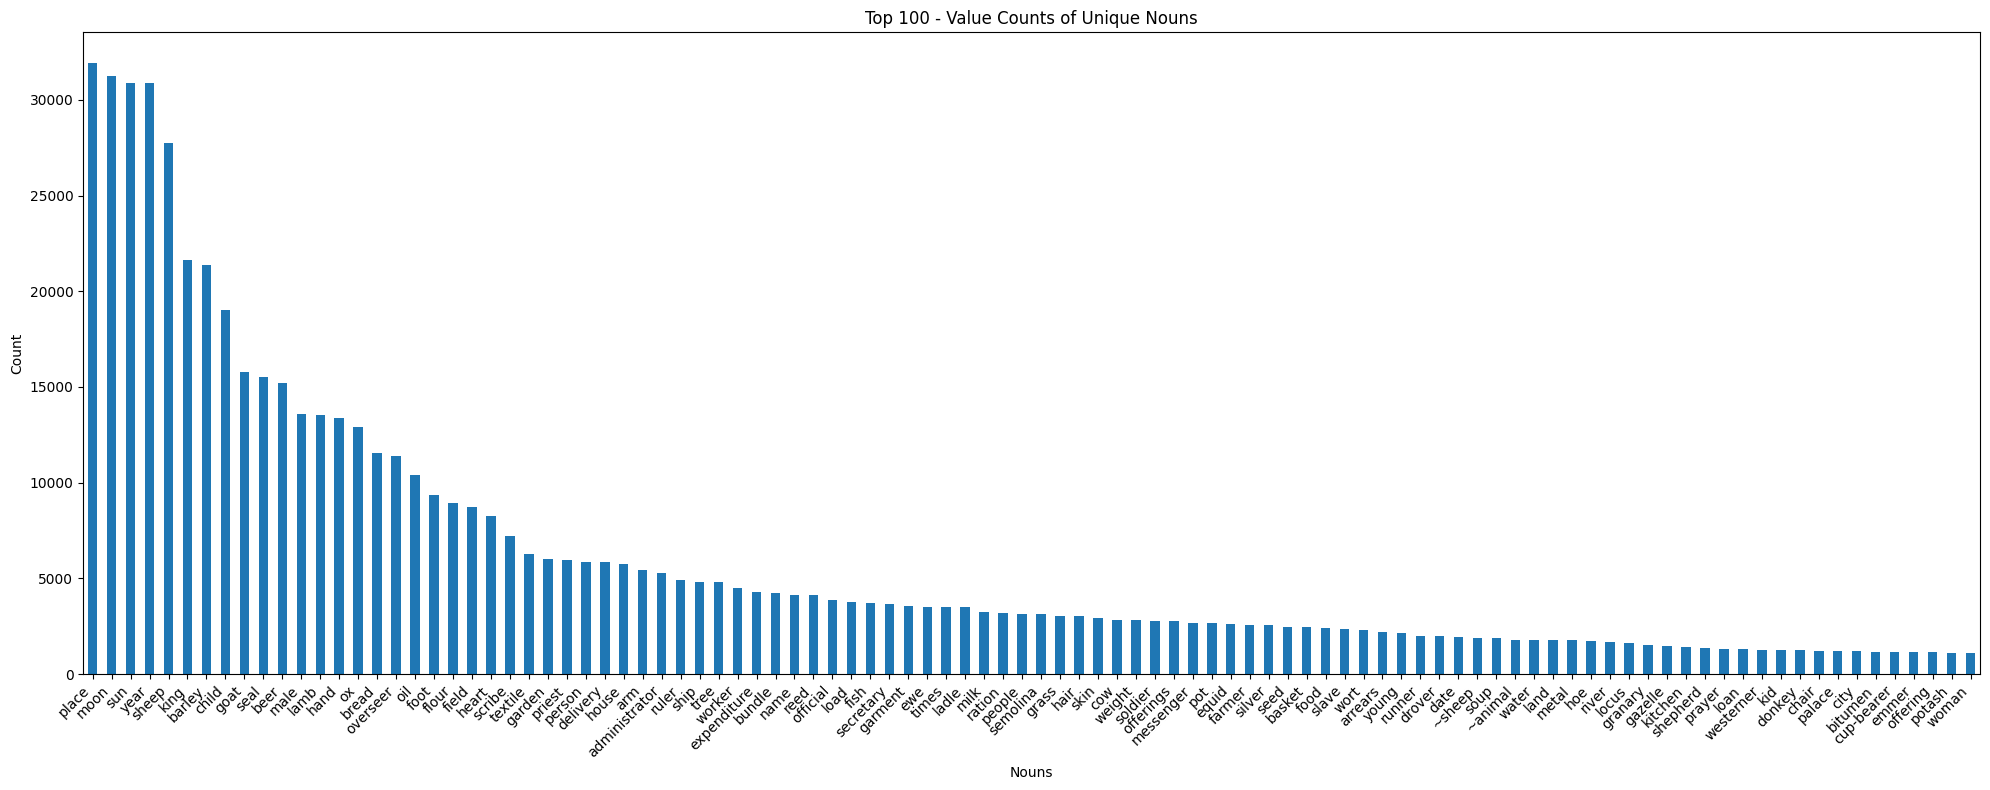

In [ ]:
import matplotlib.pyplot as plt

noun_series = pd.Series(all_nouns)
noun_series = noun_series.value_counts()

top_100_nouns = noun_series.head(100)

# Plot the value counts of the Top 100 unique translated nouns
plt.figure(figsize=(20, 8))
top_100_nouns.plot(kind='bar')
plt.title('Top 100 - Value Counts of Unique Nouns')
plt.xlabel('Nouns')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()